In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data import parent_labeler
from sentimentanalyser.data.text import TextList

In [3]:
from sentimentanalyser.preprocessing.processor import TokenizerProcessor
from sentimentanalyser.preprocessing.processor import NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [4]:
from functools import partial

In [5]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [6]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [7]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [8]:
imdb_data = ll_imdb.clas_databunchify(64)

In [9]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import CudaCallback, GradientClipping
from sentimentanalyser.callbacks.training import LRFindCustom
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamSchedulerCustom
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import RecorderCustom
from sentimentanalyser.training.trainer import Trainer

In [10]:
from sentimentanalyser.utils.dev import print_dims
from sentimentanalyser.utils.metrics import accuracy
from sentimentanalyser.utils.callbacks import create_phases

In [11]:
from sentimentanalyser.models.rnn import AttnAWDModel
from sentimentanalyser.optimizers import adam_opt

In [12]:
import torch
import torchtext
from torch import nn
from torchtext import vocab
import matplotlib.pyplot as plt

In [13]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [14]:
glove_eng = vocab.GloVe(cache=path_cache)

In [15]:
local_vocab = proc_num.vocab

In [16]:
def get_basic(Model, num_layers=2):
    model = Model(proc_num.vocab, glove_eng,num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    opt = adam_opt()(model.parameters())
    return model, loss_func, opt

In [17]:
finder = Trainer(imdb_data,*get_basic(AttnAWDModel),cb_funcs=[LRFindCustom,
                                                              RecorderCustom,
                                                              ProgressCallback,
                                                              CudaCallback])

In [18]:
finder.fit()

/home/anukoolpurohit/Documents/Workspace/MachineLearningExperiment/Text-Experiments/Sentiment Analysis/sentimentanalyser/optimizers/stats.py:25: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)


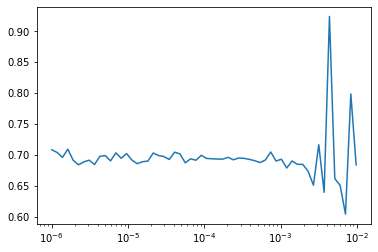

In [19]:
finder.recorder_custom.plot(skip_last=20)

In [20]:
lr = 3e-3
pct_start = 0.5
phases = create_phases(pct_start)

In [21]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [22]:
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [23]:
cbfs = [partial(AvgStatsCallback, [accuracy]),
        partial(ParamSchedulerCustom,'lr', [sched_lr]),
        partial(ParamSchedulerCustom, 'mom', [sched_mom]),
        partial(GradientClipping, clip=0.1),
        ProgressCallback,
        CudaCallback,
        RecorderCustom
       ]

In [24]:
trainer = Trainer(imdb_data, *get_basic(AttnAWDModel), cb_funcs=cbfs)

In [ ]:
trainer.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.462442,0.777720,0.289642,0.876440,01:38
1,0.291676,0.882720,0.251357,0.897240,01:38
2,0.213994,0.917160,0.264034,0.900920,01:37


/home/anukoolpurohit/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/utils/clip_grad.py:24: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  parameters = list(filter(lambda p: p.grad is not None, parameters))


In [ ]:
trainer.recorder_custom.plot_lr()